<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures
import pandas as pd
import re
from threading import Thread
import collections

In [46]:
def get_players_links(n_pages):
    offset = range(0,60*n_pages,60)
    player_links = []

    for offset_value in offset:
        r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
        all_players_page = bs(r.content)
        tables = all_players_page.select('td.col-name')
        for table in tables:
            a_tag = table.find('a')
            url = a_tag['href']
            if 'player' in url and 'players' not in url:
                player_links.append('https://sofifa.com' + url)

    counter = collections.Counter(player_links)
    return [i[0] for i in counter.most_common()]


In [47]:
def scrape_player_link(table):
  a_tag = table.find('a')
  url = a_tag['href']
  if 'player' in url and 'players' not in url:
    final = 'https://sofifa.com' + url
    # print(final)
    return final

In [ ]:
def scrape_player_links(offset_val):
  player_urls = []
  threads = []
  r = requests.get((f'https://sofifa.com/players?offset={offset_val}'))
  page_content = bs(r.content)
  tables = page_content.select('td.col-name')
  for table in tables:
    thread = Thread(target= lambda q, t: q.append(scrape_player_link(table)), args=(player_urls, table))
    thread.start()
    threads.append(thread)
  for t in threads:
    t.join()
  return player_urls

In [ ]:
def get_player_links(n_pages):
  threads = []
  que = []
  for offset_value in range(0,60*n_pages,60):
    thread = Thread(target= lambda q, offset: q.extend(scrape_player_links(offset)), args=(que, offset_value))
    thread.start()
    threads.append(thread)
  for t in threads:
    t.join()
  # que = list(filter(None, que))
  return que

In [48]:
def get_name(player_page):

    name_div = player_page.find('div',attrs={'class':'info'})
    return [('Name',name_div.find('h1').get_text())]

def get_section_box(player_page):

    info_list = []

    for initial_info in player_page.select('section'):
        text = initial_info.get_text()
    
    if 'M' in text:
        text = text.replace('M','')
    if 'K' in text:
        text = text.replace('K','')
    
    pattern = re.compile(r'[+-]\d{1,2}')
    if pattern.findall(text):
        for i in pattern.findall(text):
            text = text.replace(i,'').strip()

    
    pattern_num = re.compile(r'\d+[\.\d+]*')
    pattern_text = re.compile(r'[A-Za-z]+')
    
    num_list = pattern_num.findall(text)
    char_list = pattern_text.findall(text)
    char_list[0] += ' ' + char_list[1]
    char_list.pop(1)

    for i in range(len(num_list)):
        info_list.append((char_list[i],float(num_list[i])))

    return info_list

def get_skills(player_page):

    valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

    info_list = []
    divs = [i for i in player_page.select('div.card')]

    valid_divs = []
    for i in divs:
        if i.select('h5'):
            if i.select('h5')[0].get_text() in valid_fields:
                valid_divs.append(i)

    
    for i in valid_divs:
        info = [j.get_text().strip() for j in i.select('li')]
        
        for j in info:
            pattern_num = re.compile(r'\d+')
            pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

            try:
                num = pattern_num.findall(j)[0]
                char = pattern_text.findall(j)[0]
                info_list.append((char,float(num)))
                
            except:
                pass


    return info_list

def get_height_weight(player_page):

    info_list = []

    all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
    nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
    info_list.append(('Nationality',nationality))

    body_measures = ['Age','Height','Weight']

    pattern = re.compile(r'\d+[c|k|y]')
    values = pattern.findall(all_text)

    for i in range(len(values)):
        info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

    return info_list


def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)

    a = get_section_box(player_page)
    b = get_name(player_page)
    c = get_skills(player_page)
    d = get_height_weight(player_page)

    return a + b + c + d

In [49]:
def get_and_save_df(n_pages,name):
    player_links = get_players_links(n_pages)
    print(len(player_links))
    result = []
    i = 0
    for link in player_links:
        info_dict = {i[0]:i[1] for i in get_player_info(link)}
        result.append(info_dict)
        i += 1
        if i % 30 != 0:
            print(i, end = ' ')
        else:
            print(i)
    df = pd.DataFrame(result)

    if 'Marking' in df.columns:
        df.drop('Marking',1,inplace=True)

    df.dropna(inplace=True)

    df.to_csv(f'{name}.csv')
    return df

In [ ]:
df2 = get_and_save_df(10,'data2')

In [ ]:
df2.info()

In [ ]:
df2.head

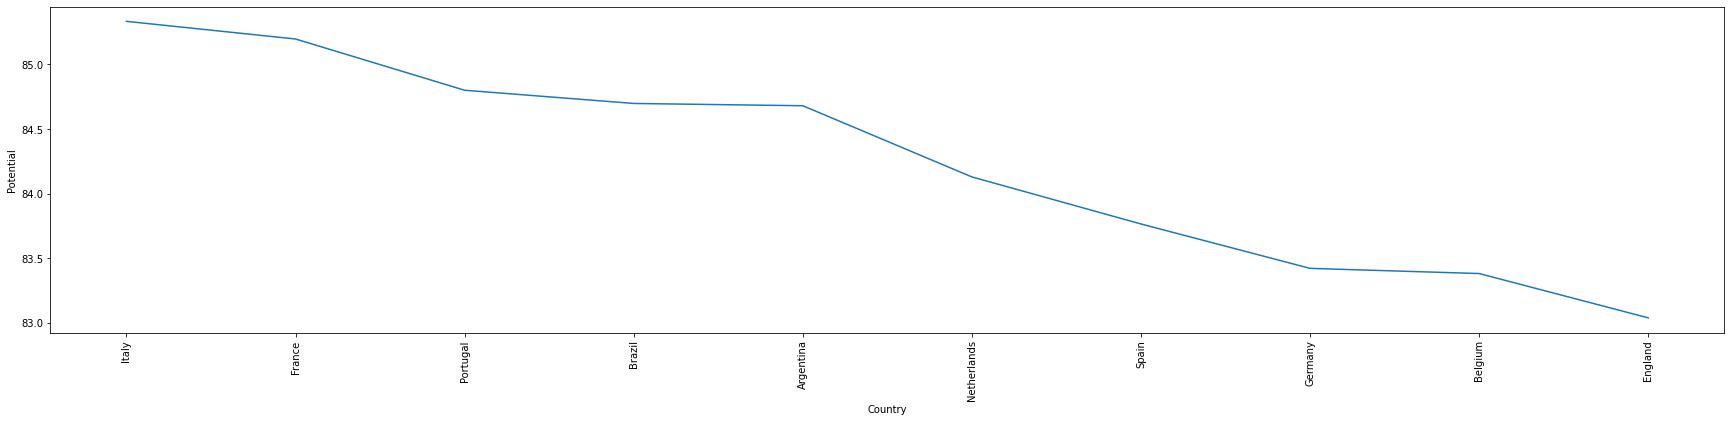

In [76]:
def plot_average_attr_country(df,n_top_countries,attribute):

    nations_group = df.groupby('Nationality')
    temp = [(nation,df1['Name'].count(),df1[attribute].sum()/df1[attribute].count()) for nation, df1 in nations_group]
    temp.sort(key=lambda x:x[1],reverse=True)
    
    if n_top_countries <= len(temp):
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')
    
    else:
        print('chutiye itne desh hi nahi hai, itne se kaam chalale\n')
        n_top_countries = len(temp)
        temp2 = [(temp[i][0],temp[i][2]) for i in range(n_top_countries)]
        temp2.sort(key=lambda x:x[1],reverse=True) 
        top_countries = [temp2[i][0] for i in range(n_top_countries)]
        attr_value = [temp2[i][1] for i in range(n_top_countries)]
        plt.figure(figsize=(30,6))
        plt.xticks(rotation = 90)
        plt.plot(top_countries,attr_value)
        plt.xlabel(f'Country')
        plt.ylabel(f'{attribute}')

plot_average_attr_country(df2,10,'Potential')

In [ ]:
# #imdb
# import requests
# from bs4 import BeautifulSoup as bs

# def get_movie_links(n_pages):

#     all_movie_links = []

#     url = 'https://www.imdb.com/search/title/?country_of_origin=IN&start=201&ref_=adv_nxt'
#     start_values = range(1,n_pages*50,50)
#     for start in start_values:
#         url = f'https://www.imdb.com/search/title/?country_of_origin=IN&start={start}&ref_=adv_nxt'
#         r = requests.get(url)
#         all_links_page = bs(r.content)
#         h3_tags = all_links_page.select('h3')
#         for tag in h3_tags:
#             try:
#                 movie_url = tag.find('a')['href']
#                 full_url = f'https://www.imdb.com{movie_url}?ref_=adv_li_tt'
#                 all_movie_links.append(full_url)
            
#             except:
#                 pass
        

#     return all_movie_links
# all_links = get_movie_links(30) 